In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [5]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [6]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
df = df.entry.apply(parse_log_entry)

<AxesSubplot:title={'center':'Top 10 Most Commonly Requested Pages'}>

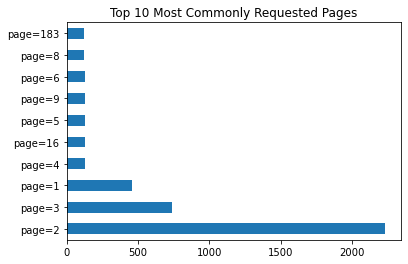

In [7]:
# Synthetic data
new = pd.DataFrame([
    ["95.31.18.119", "21/Apr/2019 10:02:41", "GET", "/api/v1/items/", "HTTP/1.1", '200', 1153005, "python-requests/2.21.0"],
    ["95.31.16.121", "17/Apr/2019 19:36:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 1005, "python-requests/2.21.0"],
    ["97.105.15.120", "18/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '301', 2560, "python-requests/2.21.0"],
    ["97.105.19.58", "19/Apr/2019 19:42:41", "GET", "/api/v1/sales?page=79/", "HTTP/1.1", '200', 2056327, "python-requests/2.21.0"],
], columns=df.columns)

df = df.append(new)

df['size_mb'] = df['size'] / 1024 / 1024
df.timestamp = pd.to_datetime(df.timestamp, utc=True)
df = df.set_index('timestamp')
df.head()

request_path_and_params = df.request_path.str.split('?', expand=True)
request_path_and_params.columns = ['request_path', 'request_params']
df = df.drop(columns='request_path').join(request_path_and_params)

df.request_params.value_counts().head(10).plot.barh(
    title='Top 10 Most Commonly Requested Pages',
)

    Interesting that page 2 is the most requested, and page 1 is the #3. Also page 183 makes the top 10.

In [ ]:
df = df.tz_convert('America/Chicago')
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()

df.hour.value_counts().sort_index().plot.bar(title='Which hours are the most active?')

    The afternoon seems to be the most common time, followed by the evening

In [ ]:
df.groupby('hour').request_params.value_counts(normalize=True).sort_values()

In [ ]:
* Whoever is working very early in the morning only requested page 1
* At 7:00 people either request page 2 or 3

In [9]:
df.groupby('request_params').hour.value_counts(normalize=True).sort_values()

The requests to pages that don't exist only happened at 2:00.

df.groupby('weekday').request_params.value_counts(normalize=True)

SyntaxError: invalid syntax (<ipython-input-9-00e881188602>, line 3)

    There's a couple requests for page 79 on thursday and friday.